In [420]:
from sklearn.model_selection import train_test_split
import onnxruntime as rt
import onnx
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from skl2onnx import convert_sklearn
from sklearn.preprocessing import StandardScaler
# define a XGBoost classifier
import xgboost as xgb
import warnings
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin


warnings.filterwarnings("ignore")  # Ignore runtime warnings
# Temporarily adjust pandas display settings for large DataFrames
pd.set_option('display.max_rows', 100)  # Ensure 100 rows can be displayed
pd.set_option('display.max_columns', None)  # Ensure all columns can be displayed
pd.set_option('display.width', None)  # Automatically adjust display width to terminal size
pd.set_option('display.max_colwidth', None)  # Ensure full width of column content is shown
pd.set_option('display.float_format', '{:.4f}'.format)  # Format the float numbers for better readability

# Data preprocessing and feature selection

Our data consists of binary data so we only want to calculate the Z-score for non-binary colomns

In [421]:
# Load the dataset
data = pd.read_csv('data/synth_data_for_training.csv')

Before cleaning:
Missing values per column:
Total missing values: 0


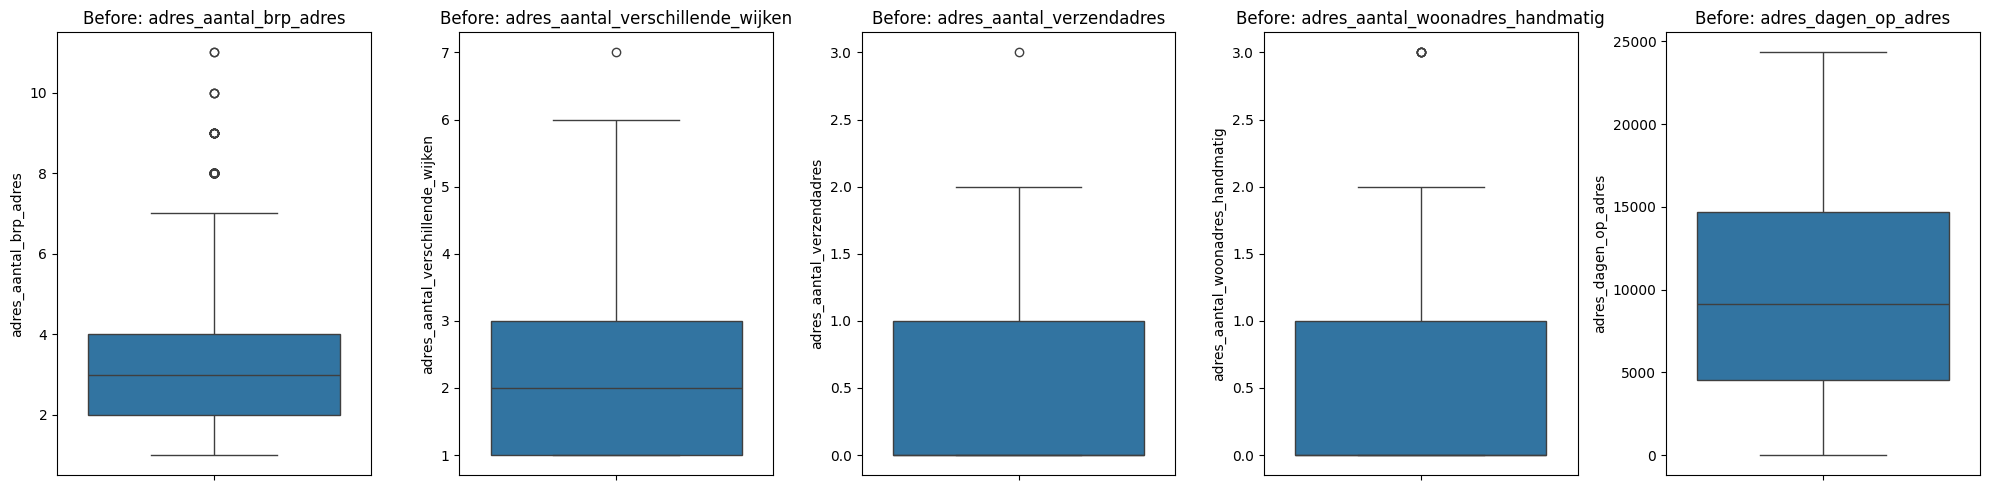

After cleaning:
Missing values per column:
Total missing values: 0


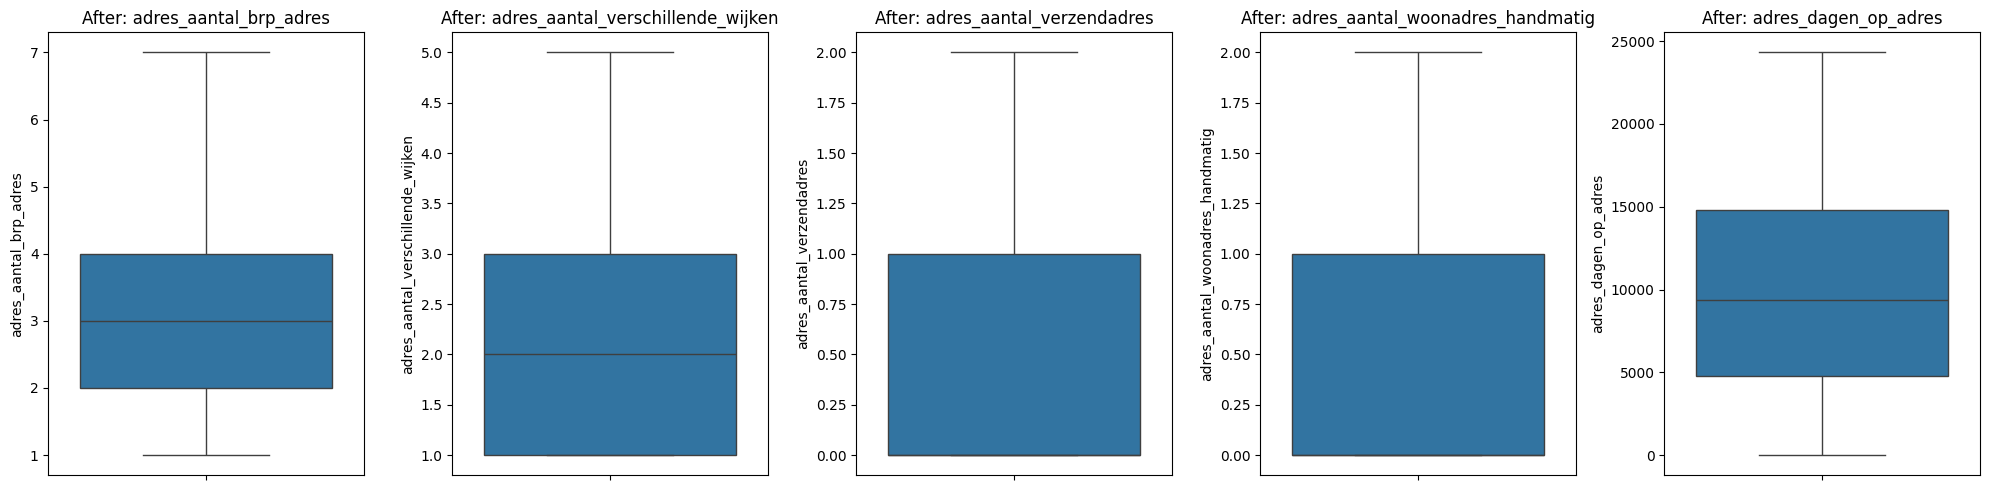

Shape before cleaning: (12645, 316)
Shape after cleaning: (10182, 316)


In [422]:
print("Before cleaning:")
print("Missing values per column:")
print("Total missing values:", data.isna().sum().sum())

# Identify non-binary columns
non_binary_columns = [col for col in data.columns if not (np.isin(data[col].unique(), [0, 1]).all() and len(data[col].unique()) == 2)]

# Calculate Z-scores for non-binary columns only
z_scores_non_binary = np.abs(stats.zscore(data[non_binary_columns], nan_policy='omit'))

# Mask to identify rows with outliers in non-binary columns
outlier_mask = (z_scores_non_binary > 3.5).any(axis=1)

# Select a subset of non-binary columns for plotting to avoid large image sizes
plot_columns = non_binary_columns[:5]  # Adjust this number based on your specific needs

# Plot outliers for the selected columns before removing
plt.figure(figsize=(20, 5))
for i, col in enumerate(plot_columns, 1):
    plt.subplot(1, len(plot_columns), i)
    sns.boxplot(y=data[col])
    plt.title(f'Before: {col}')
plt.tight_layout()
plt.show()

# Remove outliers from the dataset using the previously defined full_outlier_mask
data_cleaned = data[~outlier_mask]

print("After cleaning:")
print("Missing values per column:")
print("Total missing values:", data_cleaned.isna().sum().sum())

# Plot outliers for the selected columns after removing
plt.figure(figsize=(20, 5))
for i, col in enumerate(plot_columns, 1):
    plt.subplot(1, len(plot_columns), i)
    sns.boxplot(y=data_cleaned[col])
    plt.title(f'After: {col}')
plt.tight_layout()
plt.show()

# Print the shape of the dataset before and after cleaning
print("Shape before cleaning:", data.shape)
print("Shape after cleaning:", data_cleaned.shape)

In [423]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class FeatureZeroing(BaseEstimator, TransformerMixin):
    def __init__(self, non_fair_keywords):
        self.non_fair_keywords = non_fair_keywords
        self.removed_features = []  # Initialize list of zeroed features

    def fit(self, X, y=None):
        # No fitting process needed for zeroing features, but method required for pipeline compatibility
        return self

    def transform(self, X):
        # Convert DataFrame to a copy to avoid changing original data
        X_transformed = X.copy()

        # Make the keywords case-insensitive
        non_fair_keywords_lower = [keyword.lower() for keyword in self.non_fair_keywords]

        # Identify and zero out non-fair features
        for feature in X_transformed.columns:
            if any(nfk in feature.lower() for nfk in non_fair_keywords_lower):
                X_transformed[feature] = 0
                self.removed_features.append(feature)  # Track zeroed features

        # Return modified DataFrame
        return X_transformed

# Define non-fair keywords (same as before)
non_fair_keywords = [
    "adres", "woonadres", "verzendadres", "buurt", "wijk", "plaats", "persoon_geslacht_vrouw", "taal", "kind", "ontheffing", "leeftijd"
]

In [425]:
# Let's specify the features and the target
y = data_cleaned['checked']
X = data_cleaned.drop(['checked'], axis=1)
X = X.astype(np.float32)
    
# Let's split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# Initialize the modified feature filter with the non-fair keywords
feature_zeroing = FeatureZeroing(non_fair_keywords=non_fair_keywords)

# Apply the feature zeroing transformation to the training dataset
X_train = feature_zeroing.transform(X_train)

# Print out all the features that have been zeroed out
print("Features zeroed out:")
for feature in feature_zeroing.removed_features:
    print(feature)

Features zeroed out:
adres_aantal_brp_adres
adres_aantal_verschillende_wijken
adres_aantal_verzendadres
adres_aantal_woonadres_handmatig
adres_dagen_op_adres
adres_recentst_onderdeel_rdam
adres_recentste_buurt_groot_ijsselmonde
adres_recentste_buurt_nieuwe_westen
adres_recentste_buurt_other
adres_recentste_buurt_oude_noorden
adres_recentste_buurt_vreewijk
adres_recentste_plaats_other
adres_recentste_plaats_rotterdam
adres_recentste_wijk_charlois
adres_recentste_wijk_delfshaven
adres_recentste_wijk_feijenoord
adres_recentste_wijk_ijsselmonde
adres_recentste_wijk_kralingen_c
adres_recentste_wijk_noord
adres_recentste_wijk_other
adres_recentste_wijk_prins_alexa
adres_recentste_wijk_stadscentru
adres_unieke_wijk_ratio
afspraak_afgelopen_jaar_monitoring_insp__wet_taaleis_na_12_mnd_n_a_v__taa04_____geen_maatregel
afspraak_afgelopen_jaar_ontheffing
afspraak_afgelopen_jaar_ontheffing_taaleis
afspraak_verzenden_beschikking_i_v_m__niet_voldoen_aan_wet_taaleis
belemmering_hist_taal
beschikbaarhei

# Feature scaling and model training

In [426]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import VarianceThreshold

classifier = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0, max_depth=1, random_state=0)

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=200)

# Initialize SelectFromModel using the classifier to determine feature importances
sfm = SelectFromModel(clf, threshold='mean')  # Adjust threshold as needed

pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('feature_selection', sfm),
    ('classification', classifier)
])

# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(n_estimators=200),
                                 threshold='mean')),
                ('classification',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=1,
                                            n_estimators=500,
                                            random_state=0))])

In [427]:
# Let's evaluate the model
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

# print confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)


Accuracy: 0.9215
Precision: 0.6293
Recall: 0.3842
F1 Score: 0.4771


array([[1804,   43],
       [ 117,   73]], dtype=int64)

In [428]:
# Let's convert the model to ONNX
onnx_model = convert_sklearn(
    pipeline, initial_types=[('X', FloatTensorType((None, X.shape[1])))],
    target_opset=12)

# Let's check the accuracy of the converted model
sess = rt.InferenceSession(onnx_model.SerializeToString())
y_pred_onnx =  sess.run(None, {'X': X_test.values.astype(np.float32)})

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)

Accuracy of the ONNX model:  0.9214531173294059


In [429]:
# Let's save the model
onnx.save(onnx_model, "model/good_model.onnx")

# Let's load the model
new_session = rt.InferenceSession("model/good_model.onnx")

# Let's predict the target
y_pred_onnx2 =  new_session.run(None, {'X': X_test.values.astype(np.float32)})

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx2[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)


Accuracy of the ONNX model:  0.9214531173294059


In [431]:
# Check how imbalanced the training and testing datasets are

y_train.value_counts(normalize=True)
# y_test.value_counts(normalize=True)

checked
0   0.9066
1   0.0934
Name: proportion, dtype: float64

In [437]:
# Metamorphic testing: (Other than fairness testing)
# If a value changes then the prediction likelihood should change too in line with the purpose of the model 
# pla_historie_ontwikkeling 0 or 25 // number of developments in PLA history

# Load the model
testing_session = rt.InferenceSession("model/good_model.onnx")


# Initialize variables to store likelihoods
likelihoods_0 = []
likelihoods_25 = []

# Iterate through each sample in the test set
for index, row in X_test.iterrows():
    # Convert the row to a DataFrame to ensure it's a DataFrame object
    X_sample = pd.DataFrame(row).transpose()

    # Make predictions for 0 developments in PLA history
    X_sample_0 = X_sample.copy()
    X_sample_0['pla_historie_ontwikkeling'] = 0
    y_proba_0 = testing_session.run(None, {'X': X_sample_0.values.astype(np.float32)})[1][0]

    # Make predictions for 25 developments in PLA history
    X_sample_25 = X_sample.copy()
    X_sample_25['pla_historie_ontwikkeling'] = 25
    y_proba_25 = testing_session.run(None, {'X': X_sample_25.values.astype(np.float32)})[1][0]

    # Append the likelihoods for both age groups
    likelihoods_0.append([y_proba_0[1]])  # Probability of class 1 (fraud) for 0 developments in PLA history
    likelihoods_25.append([y_proba_25[1]])  # Probability of class 1 (fraud) for 25 developments in PLA history

# Convert likelihoods lists to NumPy arrays
likelihoods_0 = np.array(likelihoods_0)
likelihoods_25 = np.array(likelihoods_25)

# Calculate the mean likelihoods for each group
mean_likelihood_0 = np.mean(likelihoods_0)
mean_likelihood_25 = np.mean(likelihoods_25)

print("Mean likelihood for 0 developments in PLA history:", mean_likelihood_0)
print("Mean likelihood for 25 developments in PLA history:", mean_likelihood_25)

Mean likelihood for 0 developments in PLA history: 0.12514294054090364
Mean likelihood for 25 developments in PLA history: 0.05046046257136087


In [438]:
# contacten_onderwerp_no_show // Contact subject client has not shown up for meeting
likelihoods_show = []
likelihoods_noshow = []

# Iterate through each sample in the test set
for index, row in X_test.iterrows():
    # Convert the row to a DataFrame to ensure it's a DataFrame object
    X_sample = pd.DataFrame(row).transpose()

    # Make predictions for a client that has shown up for meetings
    X_sample_show = X_sample.copy()
    X_sample_show['contacten_onderwerp_no_show'] = 0.0
    y_proba_show = testing_session.run(None, {'X': X_sample_show.values.astype(np.float32)})[1][0]

    # Make predictions for no show client
    X_sample_noshow = X_sample.copy()
    X_sample_noshow['contacten_onderwerp_no_show'] = 1.0
    y_proba_noshow = testing_session.run(None, {'X': X_sample_noshow.values.astype(np.float32)})[1][0]

    # Append the likelihoods for both age groups
    likelihoods_show.append([y_proba_show[1]])  # Probability of class 1 (fraud) for a client that has shown up for meetings
    likelihoods_noshow.append([y_proba_noshow[1]])  # Probability of class 1 (fraud) for no show client

# Convert likelihoods lists to NumPy arrays
likelihoods_show = np.array(likelihoods_show)
likelihoods_noshow = np.array(likelihoods_noshow)

# Calculate the mean likelihoods for each group
mean_likelihood_show = np.mean(likelihoods_show)
mean_likelihood_noshow = np.mean(likelihoods_noshow)

print("Mean likelihood for a client that has shown up for meetings:", mean_likelihood_show)
print("Mean likelihood for no show client:", mean_likelihood_noshow)

Mean likelihood for a client that has shown up for meetings: 0.05117296025515422
Mean likelihood for no show client: 0.07565478211708612


In [439]:
# instrument_ladder_huidig_activering // instrument ladder is currently activated
likelihoods_notactivated = []
likelihoods_activated = []

# Iterate through each sample in the test set
for index, row in X_test.iterrows():
    # Convert the row to a DataFrame to ensure it's a DataFrame object
    X_sample = pd.DataFrame(row).transpose()

    # Make predictions for a client without an activated instrument ladder
    X_sample_notactivated = X_sample.copy()
    X_sample_notactivated['instrument_ladder_huidig_activering'] = 0.0
    y_proba_notactivated = testing_session.run(None, {'X': X_sample_notactivated.values.astype(np.float32)})[1][0]

    # Make predictions for a client with an activated instrument ladder
    X_sample_activated = X_sample.copy()
    X_sample_activated['instrument_ladder_huidig_activering'] = 1.0
    y_proba_activated = testing_session.run(None, {'X': X_sample_activated.values.astype(np.float32)})[1][0]

    # Append the likelihoods for both age groups
    likelihoods_notactivated.append([y_proba_notactivated[1]])  # Probability of class 1 (fraud) for a client without an activated instrument ladder
    likelihoods_activated.append([y_proba_activated[1]])  # Probability of class 1 (fraud) for a client with an activated instrument ladder

# Convert likelihoods lists to NumPy arrays
likelihoods_notactivated = np.array(likelihoods_notactivated)
likelihoods_activated = np.array(likelihoods_activated)

# Calculate the mean likelihoods for each group
mean_likelihood_notactivated = np.mean(likelihoods_notactivated)
mean_likelihood_activated = np.mean(likelihoods_activated)

print("Mean likelihood for a client without an activated instrument ladder:", mean_likelihood_notactivated)
print("Mean likelihood for a client with an activated instrument ladder:", mean_likelihood_activated)

Mean likelihood for a client without an activated instrument ladder: 0.1059086122346615
Mean likelihood for a client with an activated instrument ladder: 0.059387841936297786


In [440]:
# instrument_reden_beeindiging_historie_succesvol // successful instrumentation history
likelihoods_not = []
likelihoods_successful = []

# Iterate through each sample in the test set
for index, row in X_test.iterrows():
    # Convert the row to a DataFrame to ensure it's a DataFrame object
    X_sample = pd.DataFrame(row).transpose()

    # Make predictions for a client without a successful instrumentation history
    X_sample_not = X_sample.copy()
    X_sample_not['instrument_reden_beeindiging_historie_succesvol'] = 0.0
    y_proba_not = testing_session.run(None, {'X': X_sample_not.values.astype(np.float32)})[1][0]

    # Make predictions for a client with a successful instrumentation history
    X_sample_successful = X_sample.copy()
    X_sample_successful['instrument_reden_beeindiging_historie_succesvol'] = 1.0
    y_proba_successful = testing_session.run(None, {'X': X_sample_successful.values.astype(np.float32)})[1][0]

    # Append the likelihoods for both age groups
    likelihoods_not.append([y_proba_not[1]])  # Probability of class 1 (fraud) for a client without a successful instrumentation history
    likelihoods_successful.append([y_proba_successful[1]])  # Probability of class 1 (fraud) for a client with a successful instrumentation history

# Convert likelihoods lists to NumPy arrays
likelihoods_not = np.array(likelihoods_not)
likelihoods_successful = np.array(likelihoods_successful)

# Calculate the mean likelihoods for each group
mean_likelihood_not = np.mean(likelihoods_not)
mean_likelihood_successful = np.mean(likelihoods_successful)

print("Mean likelihood for a client without a successful instrumentation history:", mean_likelihood_not)
print("Mean likelihood for a client with a successful instrumentation history:", mean_likelihood_successful)

Mean likelihood for a client without a successful instrumentation history: 0.12675912130329617
Mean likelihood for a client with a successful instrumentation history: 0.08492329317269866


In [441]:
# Combinatorial/fairness testing: 
# Evaluate the model's performance and predictions separately for different demographic groups (e.g., age groups, genders) and compare the outcomes to detect any disparities or biases.
# Test case sets that test age groups, gender, if they have children and if they speak another language than dutch

age_groups = {
    'young_adult': [18, 30],  # 20-64 years old
    'youngish_adult': [31, 40],  # 20-64 years old
    'middle_aged_adult': [41, 50],  # 20-64 years old
    'older_adult': [51, 60],  # 20-64 years old
    'senior': [61, 120]  # 65+ years old (assuming 120 as upper limit)
}

results = {}
X_test_age = X_test.copy()

# Extract age information from the test set
X_test_age['age_group'] = pd.cut(X_test_age['persoon_leeftijd_bij_onderzoek'], bins=[0, 30, 40, 50, 60, 120], labels=['young_adult', 'youngish_adult', 'middle_aged_adult', 'older_adult', 'senior'])

# Evaluate model performance for each age group
for group in X_test_age['age_group'].unique():
    # Filter test set for the current age group
    X_group = X_test_age[X_test_age['age_group'] == group].drop(columns=['age_group'])
    y_group = y_test[X_test_age['age_group'] == group]

    # Predict using the model
    y_pred_group = testing_session.run(None, {'X': X_group.values.astype(np.float32)})[0]

    # Calculate evaluation metrics
    accuracy_group = accuracy_score(y_group, y_pred_group)
    precision_group = precision_score(y_group, y_pred_group)
    recall_group = recall_score(y_group, y_pred_group)
    f1_score_group = f1_score(y_group, y_pred_group)

    # Store results for the current age group
    results[group] = {
        'Accuracy': accuracy_group,
        'Precision': precision_group,
        'Recall': recall_group,
        'F1 Score': f1_score_group
    }

# Print results for each age group
for group, metrics in results.items():
    print(f"Results for {group} age group:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print()


Results for middle_aged_adult age group:
Accuracy: 0.9147
Precision: 0.5208
Recall: 0.4386
F1 Score: 0.4762

Results for older_adult age group:
Accuracy: 0.9720
Precision: 0.6190
Recall: 0.5200
F1 Score: 0.5652

Results for youngish_adult age group:
Accuracy: 0.8552
Precision: 0.7667
Recall: 0.3966
F1 Score: 0.5227

Results for senior age group:
Accuracy: 0.8997
Precision: 0.3750
Recall: 0.1034
F1 Score: 0.1622

Results for young_adult age group:
Accuracy: 0.8481
Precision: 1.0000
Recall: 0.4286
F1 Score: 0.6000



In [442]:
# Gender test

# Initialize a dictionary to store results for each gender group
results = {}
X_test_gender = X_test.copy()

# Extract gender information from the test set
X_test_gender['gender'] = X_test_gender['persoon_geslacht_vrouw'].apply(lambda x: 'woman' if x == 1.0 else 'man')

# Evaluate model performance for each gender group
for group in X_test_gender['gender'].unique():
    # Filter test set for the current gender group
    X_group = X_test_gender[X_test_gender['gender'] == group].drop(columns=['gender'])
    y_group = y_test[X_test_gender['gender'] == group]

    # Predict using the model
    y_pred_group = testing_session.run(None, {'X': X_group.values.astype(np.float32)})[0]

    # Calculate evaluation metrics
    accuracy_group = accuracy_score(y_group, y_pred_group)
    precision_group = precision_score(y_group, y_pred_group)
    recall_group = recall_score(y_group, y_pred_group)
    f1_score_group = f1_score(y_group, y_pred_group)

    # Store results for the current gender group
    results[group] = {
        'Accuracy': accuracy_group,
        'Precision': precision_group,
        'Recall': recall_group,
        'F1 Score': f1_score_group
    }

# Print results for each gender group
for group, metrics in results.items():
    print(f"Results for {group} gender group:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print()

Results for woman gender group:
Accuracy: 0.9378
Precision: 0.7857
Recall: 0.3976
F1 Score: 0.5280

Results for man gender group:
Accuracy: 0.9073
Precision: 0.5405
Recall: 0.3738
F1 Score: 0.4420



In [443]:
# Language test

# Initialize a dictionary to store results for each language group
results = {}
X_test_language = X_test.copy()

# Extract language information from the test set
X_test_language['language'] = X_test_language['persoonlijke_eigenschappen_spreektaal_anders'].apply(lambda x: 'other_language' if x == 1.0 else 'not')

# Evaluate model performance for each language group
for group in X_test_language['language'].unique():
    # Filter test set for the current language group
    X_group = X_test_language[X_test_language['language'] == group].drop(columns=['language'])
    y_group = y_test[X_test_language['language'] == group]

    # Predict using the model
    y_pred_group = testing_session.run(None, {'X': X_group.values.astype(np.float32)})[0]

    # Calculate evaluation metrics
    accuracy_group = accuracy_score(y_group, y_pred_group)
    precision_group = precision_score(y_group, y_pred_group)
    recall_group = recall_score(y_group, y_pred_group)
    f1_score_group = f1_score(y_group, y_pred_group)

    # Store results for the current language group
    results[group] = {
        'Accuracy': accuracy_group,
        'Precision': precision_group,
        'Recall': recall_group,
        'F1 Score': f1_score_group
    }

# Print results for each language group
for group, metrics in results.items():
    print(f"Results for {group} language group:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print()

Results for not language group:
Accuracy: 0.9310
Precision: 0.7115
Recall: 0.3776
F1 Score: 0.4933

Results for other_language language group:
Accuracy: 0.9102
Precision: 0.5625
Recall: 0.3913
F1 Score: 0.4615



In [444]:
# children test

# Initialize a dictionary to store results for each children group
results = {}
X_test_children = X_test.copy()

# Extract gender information from the test set
X_test_children['children'] = X_test_children['relatie_kind_heeft_kinderen'].apply(lambda x: 'has_child' if x == 1.0 else 'not')

# Evaluate model performance for each children group
for group in X_test_children['children'].unique():
    # Filter test set for the current children group
    X_group = X_test_children[X_test_children['children'] == group].drop(columns=['children'])
    y_group = y_test[X_test_children['children'] == group]

    # Predict using the model
    y_pred_group = testing_session.run(None, {'X': X_group.values.astype(np.float32)})[0]

    # Calculate evaluation metrics
    accuracy_group = accuracy_score(y_group, y_pred_group)
    precision_group = precision_score(y_group, y_pred_group)
    recall_group = recall_score(y_group, y_pred_group)
    f1_score_group = f1_score(y_group, y_pred_group)

    # Store results for the current children group
    results[group] = {
        'Accuracy': accuracy_group,
        'Precision': precision_group,
        'Recall': recall_group,
        'F1 Score': f1_score_group
    }

# Print results for each children group
for group, metrics in results.items():
    print(f"Results for {group} children group:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print()

Results for not children group:
Accuracy: 0.9196
Precision: 0.5625
Recall: 0.3814
F1 Score: 0.4545

Results for has_child children group:
Accuracy: 0.9250
Precision: 0.7778
Recall: 0.3889
F1 Score: 0.5185



In [452]:
# Age test
# Initialize variables to store counts
same_predictions_count = 0
total_samples = len(X_test)

# Iterate through each sample in the test set
for index, row in X_test.iterrows():
    # Convert the row to a DataFrame to ensure it's a DataFrame object
    X_sample = pd.DataFrame(row).transpose()

    # Make predictions for age 25
    X_sample_25 = X_sample.copy()
    X_sample_25['persoon_leeftijd_bij_onderzoek'] = 25
    y_pred_25 = testing_session.run(None, {'X': X_sample_25.values.astype(np.float32)})

    # Make predictions for age 65
    X_sample_65 = X_sample.copy()
    X_sample_65['persoon_leeftijd_bij_onderzoek'] = 65
    y_pred_65 = testing_session.run(None, {'X': X_sample_65.values.astype(np.float32)})

    # Check if predictions are the same
    if y_pred_25 == y_pred_65:
        same_predictions_count += 1

# Calculate the fraction of cases where the predictions are the same
fraction_same_predictions = same_predictions_count / total_samples

print("Fraction of cases where predictions are the same for age 25 and 65:", fraction_same_predictions)

Fraction of cases where predictions are the same for age 25 and 65: 1.0


In [453]:
# Gender test
# Initialize variables to store counts
same_predictions_count = 0
total_samples = len(X_test)

# Iterate through each sample in the test set
for index, row in X_test.iterrows():
    # Convert the row to a DataFrame to ensure it's a DataFrame object
    X_sample = pd.DataFrame(row).transpose()

    # Make predictions for men
    X_sample_men = X_sample.copy()
    X_sample_men['persoon_geslacht_vrouw'] = 0.0
    y_pred_men = testing_session.run(None, {'X': X_sample_men.values.astype(np.float32)})

    # Make predictions for women
    X_sample_women = X_sample.copy()
    X_sample_women['persoon_geslacht_vrouw'] = 1.0
    y_pred_women = testing_session.run(None, {'X': X_sample_women.values.astype(np.float32)})

    # Check if predictions are the same
    if y_pred_men == y_pred_women:
        same_predictions_count += 1

# Calculate the fraction of cases where the predictions are the same
fraction_same_predictions = same_predictions_count / total_samples

print("Fraction of cases where predictions are the same for men and women:", fraction_same_predictions)

Fraction of cases where predictions are the same for men and women: 1.0


In [454]:
# Language test
# Initialize variables to store counts
same_predictions_count = 0
total_samples = len(X_test)

# Iterate through each sample in the test set
for index, row in X_test.iterrows():
    # Convert the row to a DataFrame to ensure it's a DataFrame object
    X_sample = pd.DataFrame(row).transpose()

    # Make predictions for not
    X_sample_not = X_sample.copy()
    X_sample_not['persoonlijke_eigenschappen_spreektaal_anders'] = 0.0
    y_pred_not = testing_session.run(None, {'X': X_sample_not.values.astype(np.float32)})

    # Make predictions for other
    X_sample_other = X_sample.copy()
    X_sample_other['persoonlijke_eigenschappen_spreektaal_anders'] = 1.0
    y_pred_other = testing_session.run(None, {'X': X_sample_other.values.astype(np.float32)})

    # Check if predictions are the same
    if y_pred_not == y_pred_other:
        same_predictions_count += 1

# Calculate the fraction of cases where the predictions are the same
fraction_same_predictions = same_predictions_count / total_samples

print("Fraction of cases where predictions are the same for dutch speakers and non-dutch speakers:", fraction_same_predictions)

Fraction of cases where predictions are the same for dutch speakers and non-dutch speakers: 1.0


In [455]:
# Children test
# Initialize variables to store counts
same_predictions_count = 0
total_samples = len(X_test)

# Iterate through each sample in the test set
for index, row in X_test.iterrows():
    # Convert the row to a DataFrame to ensure it's a DataFrame object
    X_sample = pd.DataFrame(row).transpose()

    # Make predictions for not
    X_sample_not = X_sample.copy()
    X_sample_not['relatie_kind_heeft_kinderen'] = 0.0
    y_pred_not = testing_session.run(None, {'X': X_sample_not.values.astype(np.float32)})

    # Make predictions for other
    X_sample_children = X_sample.copy()
    X_sample_children['relatie_kind_heeft_kinderen'] = 1.0
    y_pred_children = testing_session.run(None, {'X': X_sample_children.values.astype(np.float32)})

    # Check if predictions are the same
    if y_pred_not == y_pred_children:
        same_predictions_count += 1

# Calculate the fraction of cases where the predictions are the same
fraction_same_predictions = same_predictions_count / total_samples

print("Fraction of cases where predictions are the same for people with or without children:", fraction_same_predictions)

Fraction of cases where predictions are the same for people with or without children: 1.0
